Copyright 2022 NVIDIA Corporation. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: center;">

# Triton Client

## Overview

In this notebook we are deploying Huggingface model namely [xtremedistil-l6-h256-uncased](https://huggingface.co/microsoft/xtremedistil-l6-h256-uncased) model which is an extremely distilled version of BERT. In particular, we are using the version of this model that was finetuned on [emotion classification](https://huggingface.co/bergum/xtremedistil-emotion) downstream task. To generate the Torchscript and TensorRT models we ran the [export_models.sh](./export_models.sh) script inside the latest [NGC Pytorch container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch) using [generate_models.sh](./generate_models.sh)

## Imports & Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pathlib
import xdistilbert_emotion_classification_client
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from IPython.display import display, HTML
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 24em; }</style>"))

## Check on Triton Server

We can test the status of the server connection by running the curl command: `curl -v <IP of machine>:8000/v2/health/ready` which should return `HTTP/1.1 200 OK`

**NOTE:-** In our case the IP of machine on which Triton Server is currently running is `localhost`

In [ ]:
!curl -v localhost:8000/v2/health/ready

## Perform Sample Inference

In [ ]:
texts = ["I feel irritated and rejected without anyone doing anything or saying anything",
         "I become overwhelmed and feel defeated."
        ]

In [ ]:
xdistilbert_emotion_classification_client.request_inference(texts,
                              model_name="xdistilbert_pt",
                              triton_url="localhost:8000")

## Determine throughput and latency with Perf Analyzer <a class="anchor" id="PerfAnalyzer"></a>

Now that we have deployed our object detection model for inference in Triton, we can measure its inference performance using Triton's `perf_analyzer` tool. The perf_analyzer application generates artificial inference requests to the deployed model and measures the throughput and latency of those requests. For more information on `perf_analyzer` utility, please refer to this [link.](https://github.com/triton-inference-server/server/blob/main/docs/perf_analyzer.md)

The below command will return a JSON representation of the current model configuration. 

In [ ]:
!curl localhost:8000/v2/models/xdistilbert_pt/config | python3 -m json.tool

## Pytorch Torchscript Model Performance on GPU

In [ ]:
!perf_analyzer -u localhost:8000 -m xdistilbert_pt --input-data ./perf_inputs/input_pt1.json --percentile=95 --concurrency-range=16

## Switching to TensorRT

In [ ]:
!curl localhost:8000/v2/models/xdistilbert_trt/config | python3 -m json.tool

In [ ]:
!perf_analyzer -u localhost:8000 -m xdistilbert_trt --input-data ./perf_inputs/input_trt1.json --percentile=95 --concurrency-range=16

### Unload Pytorch backend model

We will now move the Pytorch backend DistillBERT model out of model repository to unload it from Triton Inference Server so that we can focus on the TensorRT DistillBERT model.

In [ ]:
!mv /workspace/model_repository/xdistilbert_pt /workspace/

## Concurrent Model Execution

Now let's enable Concurrent Model Execution in Triton by changing the config of the TRT model to have 2 instances of the same model running. The model config file is located at [model_repository/xdistilbert_trt/config.pbtxt](./model_repository/xdistilbert_trt/config.pbtxt). We don't need to reload the triton server here as it will pull the latest config.pbtxt automatically in polling mode.

Add the following lines at the end of the `config.pbtxt` file.
```
instance_group [
   {
     count: 2
     kind: KIND_GPU
   }
]
```

In [ ]:
!curl localhost:8000/v2/models/xdistilbert_trt/config | python3 -m json.tool

In [ ]:
!perf_analyzer -u localhost:8000 -m xdistilbert_trt --input-data ./perf_inputs/input_trt1.json --percentile=95 --concurrency-range=16

## Dynamic Batching

The dynamic batcher allows Triton to handle a higher number of concurrent requests because those requests are combined for inference.

Replace the config of concurrent execution with the following lines at the end of the `config.pbtxt` file to enable dynamic batching. So we will see the performance that just dynamic batching can bring us.

```
dynamic_batching { 
    preferred_batch_size: [4, 8, 16]
    max_queue_delay_microseconds: 100
}

```

In [ ]:
!curl localhost:8000/v2/models/xdistilbert_trt/config | python3 -m json.tool

In [ ]:
!perf_analyzer -u localhost:8000 -m xdistilbert_trt --input-data ./perf_inputs/input_trt1.json --percentile=95 --concurrency-range=16

## Dynamic Batching + Concurrent Execution

Add the concurrent execution to the model config on top of Dynamic Batching to have both features turned on

```
instance_group [
   {
     count: 2
     kind: KIND_GPU
   }
]
```

In [ ]:
!curl localhost:8000/v2/models/xdistilbert_trt/config | python3 -m json.tool

In [ ]:
!perf_analyzer -u localhost:8000 -m xdistilbert_trt --input-data ./perf_inputs/input_trt1.json --percentile=95 --concurrency-range=16

## Model Analyzer Can Automate Searching for Best Configuration

[Triton Model Analyzer](https://github.com/triton-inference-server/model_analyzer) is a CLI tool to help with better understanding of the compute and memory requirements of the Triton Inference Server models. These reports will help the user better understand the trade-offs in different configurations and choose a configuration that maximizes the performance of Triton Inference Server.
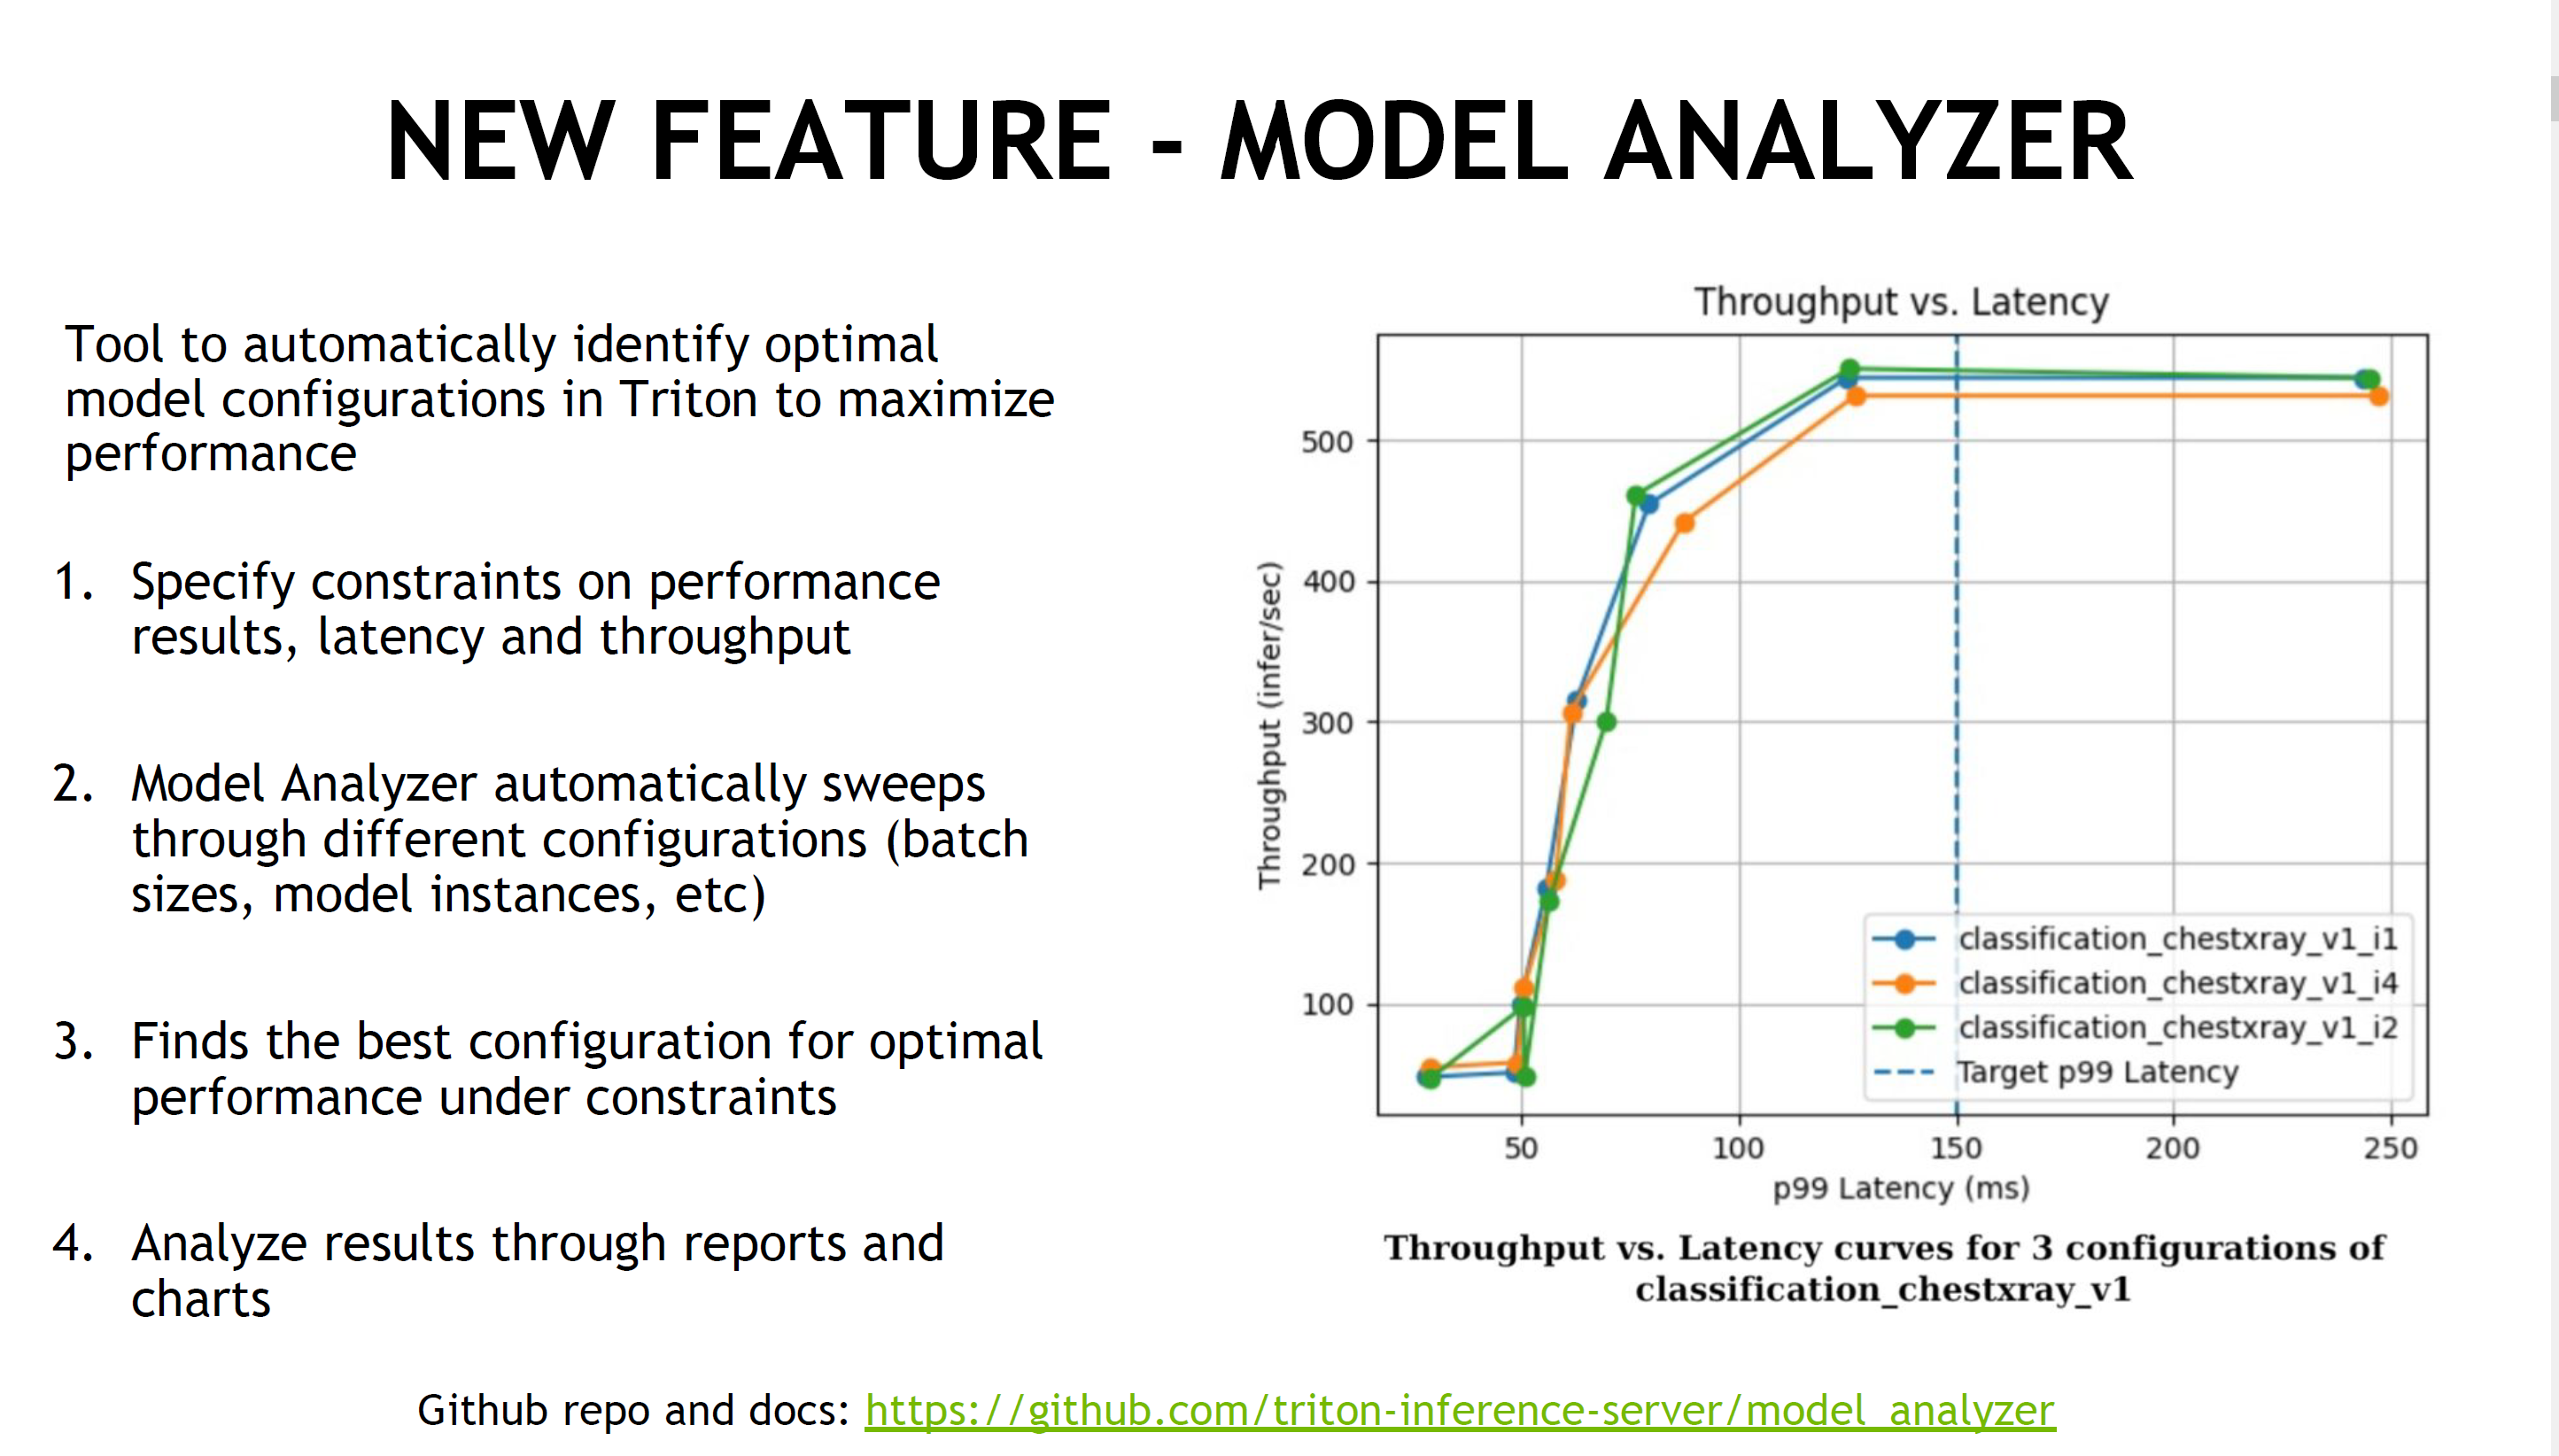

## Model Navigator can Automate the Triton Deployment

The [Triton Model Navigator](https://github.com/triton-inference-server/model_navigator) is a tool that provides the ability to automate the process of moving model from source to optimal format and configuration for deployment on Triton Inference Server. The tool support export model from source to all possible formats and apply the Triton Inference Server backend optimizations. Finally, it uses the Triton Model Analyzer to find the best Triton Model configuration, matches the provided constraints, and optimize performance.

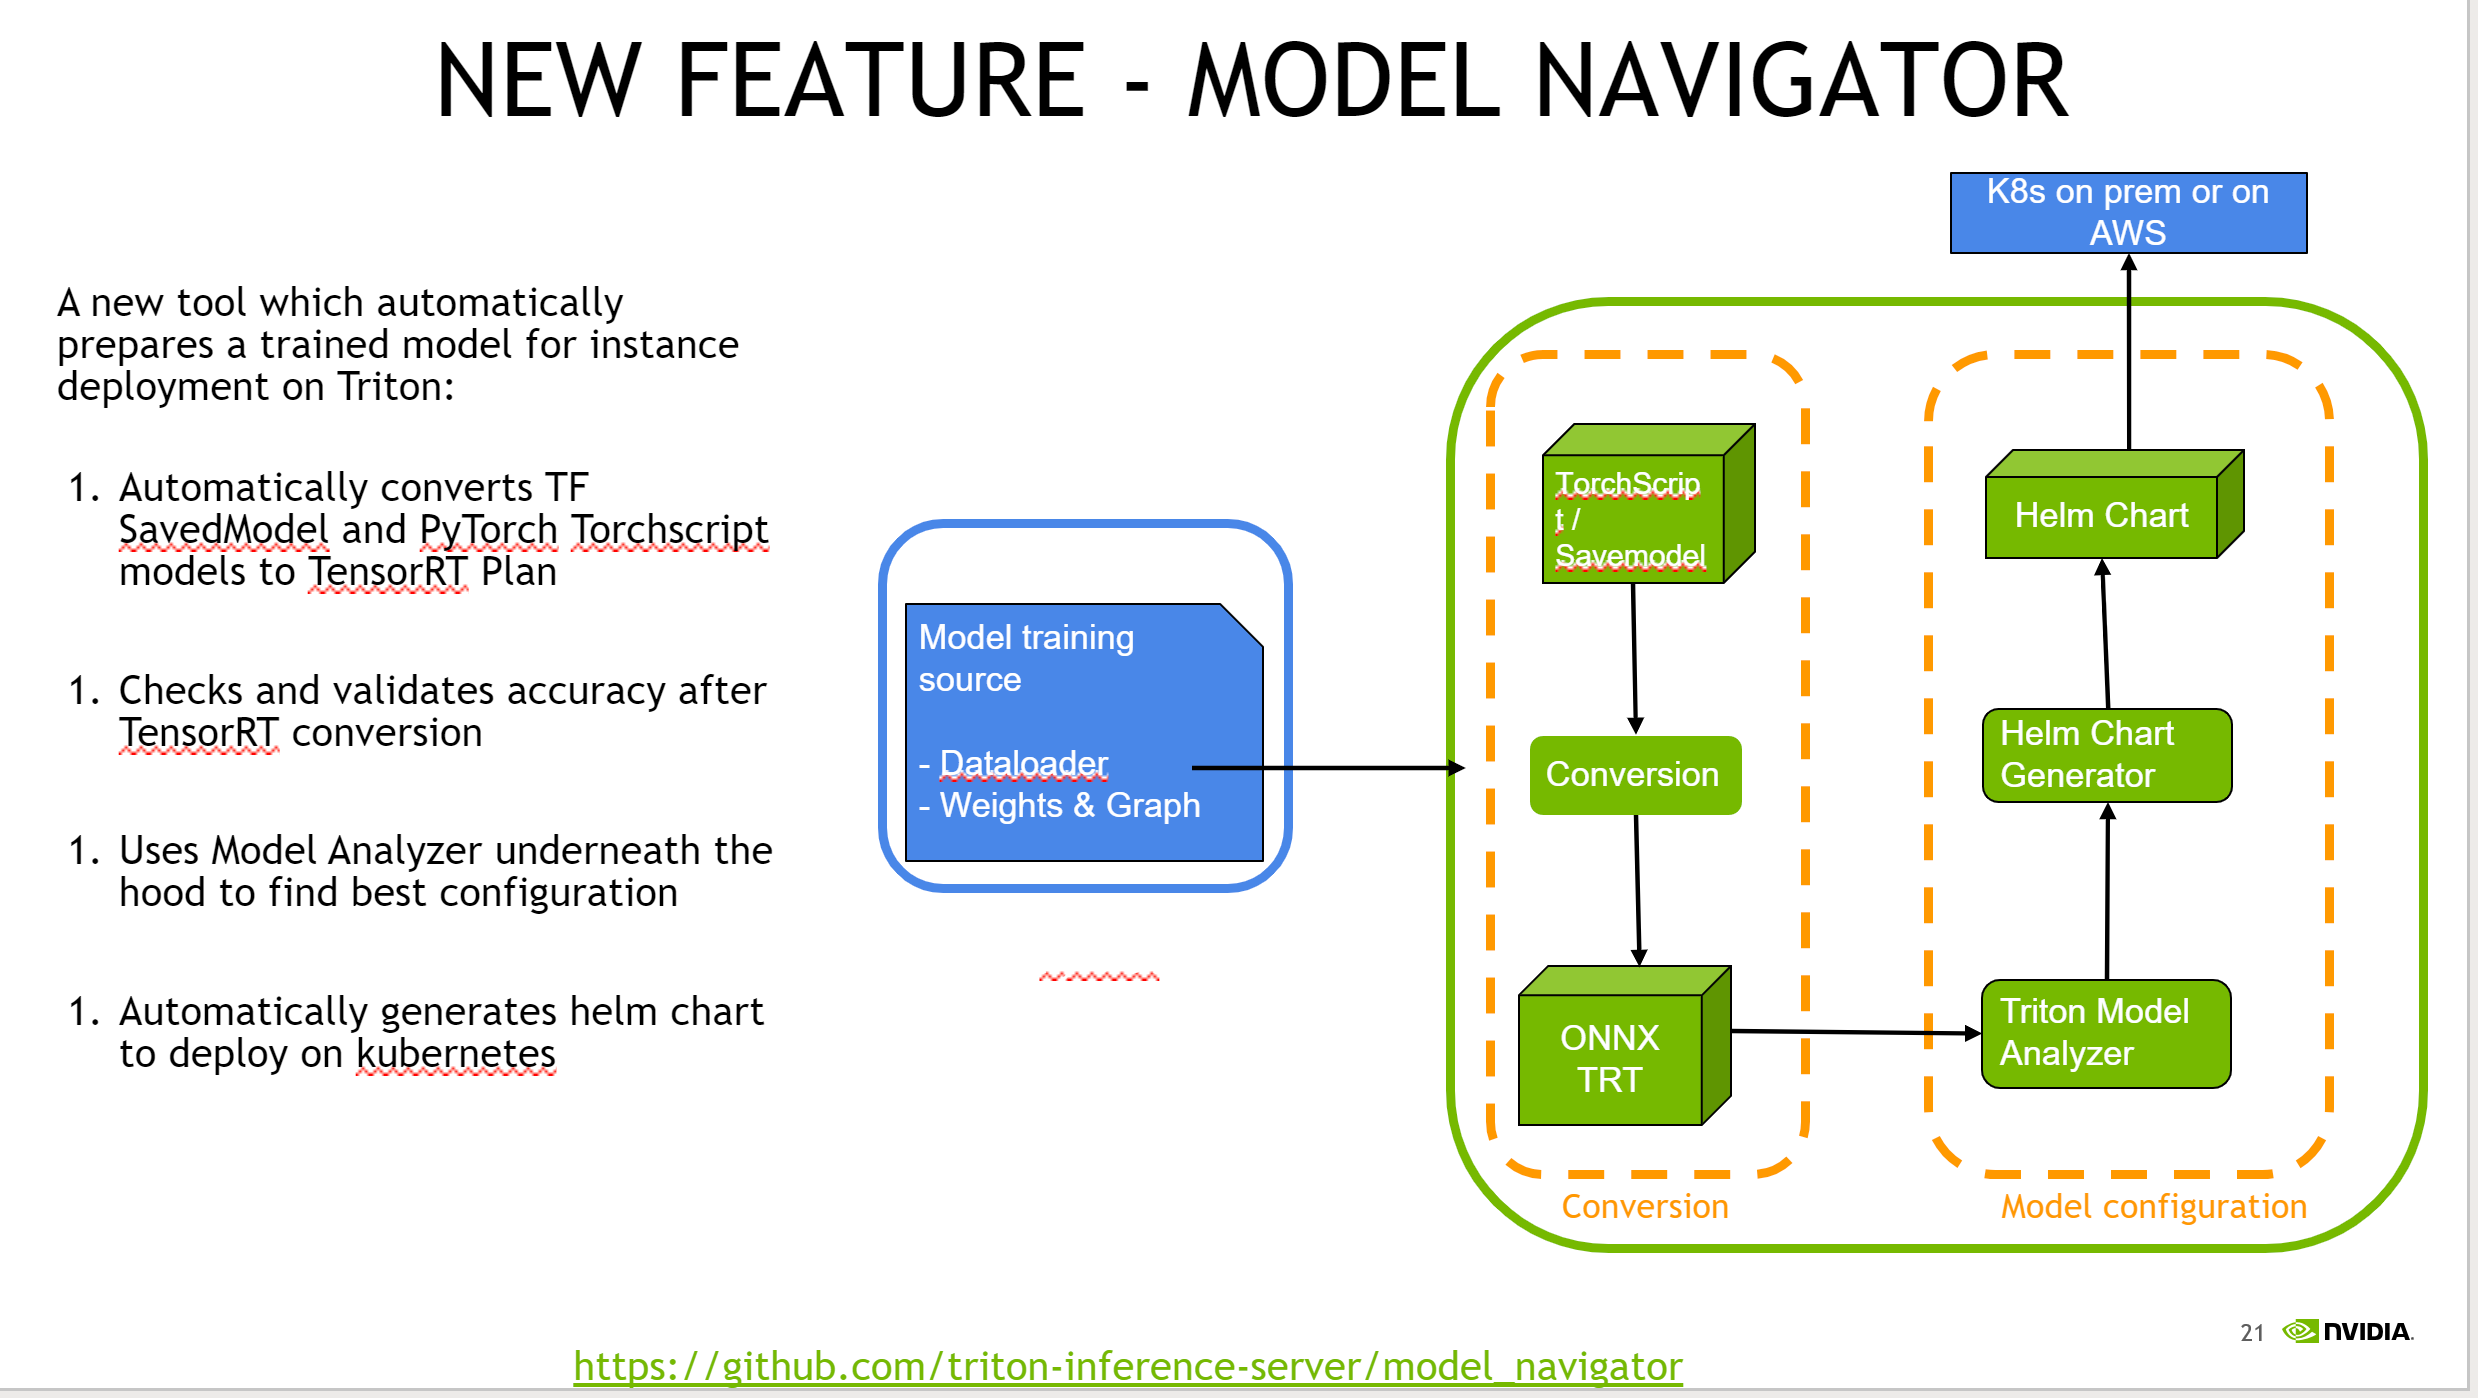

## CLEAN UP - Shutdown All Jupyter Kernels

Go to **Kernels -> Shutdown all Kernels** to kill Triton server once you are done with the `triton_client.ipynb` and `triton_server.ipynb` notebooks.

# Model Analyzer Demo Instructions

To run the [3_model_analyzer notebook](./3_model_analyzer.ipynb) please shut down current jupyterlab, and exit out of the current docker container. 

Then 
1. run `bash docker_model_analyzer.sh` to launch the Docker container for Model Analyzer
2. launch Jupyter by running `bash start_jupyter.sh`
3. open the [3_model_analyzer notebook](./3_model_analyzer.ipynb)